In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
import json
import gff3_parsing
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import glob

In [20]:
def analyze_genome(dataframe, energy_dict, gaps = (4,10), expected_len = 20):
    
    for index in dataframe.index:
        upstream = dataframe.loc[index,"upstream_sequence"]
        test_string = upstream.replace("T", "U")
        if len(test_string) != expected_len:
            continue
        if test_string.count("A") + test_string.count("U") +\
                                    test_string.count("C") + test_string.count("G") != expected_len:
            continue
            
        energy_list = []
        for gap in range(gaps[0],gaps[1]+1):
             energy_list.append(energy_dict[test_string[-gap - 6: -gap]])

        dataframe.at[index, "energy_binding"] = min(energy_list)
    return dataframe

In [16]:
with open('../Data/examples_for_testing/energyRef_CCUCCU_mfe.json', 'r') as infile:
       energy_dict = json.load(infile)


host_df, host_genome = gff3_parsing.compile_sequences("../Data/examples_for_testing/ecoli.gff3",\
                                                    "../Data/examples_for_testing/ecoli.fasta", 20)

host_df = analyze_genome(host_df, energy_dict)

In [21]:
mean_difs = []

p_values = []
for gff_file in glob.glob("../Data/ecoli_viruses/562_rep_viruses_concat/*.gff"):
    #print(gff_file)
    fasta_file = "../Data/ecoli_viruses/562_rep_viruses/" + gff_file.split("/")[-1].replace("gff", "fasta")
    
    viral_df, viral_genome = gff3_parsing.compile_sequences(gff_file,fasta_file, 20)
    viral_df = analyze_genome(viral_df, energy_dict)

    #print(stats.ranksums(host_df["energy_binding"], viral_df["energy_binding"]))
    rstat, p_value = stats.ranksums(host_df["energy_binding"], viral_df["energy_binding"])
    p_values.append(p_value)
    
    mean_difs.append(np.mean(viral_df["energy_binding"]) - np.mean(host_df["energy_binding"]))
    

In [22]:
print(len(mean_difs))
print(len(p_values))

373
373


# To-Do: 

1. How many/what percent/proportion of p-values are < 0.01
2. distribution of p-values, mean_difs
3. Count the negatives (put as fraction /373)
4. How many cases where host is stronger, is the p_value still significant?
5. Scatterplot of p_values, mean_difs


In [13]:
#1
significant_pvalues = []
for p in p_values:
    if p <= 0.01:
        significant_pvalues.append(p)
        
print(len(significant_pvalues))

239


In [14]:
#proportion of significant p-values
len(significant_pvalues)/len(p_values)

0.6407506702412868

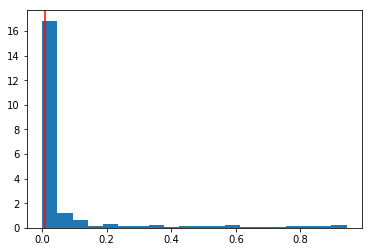

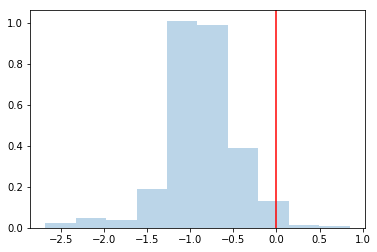

In [26]:
#2
fig, ax = plt.subplots()
ax.hist(p_values, 20, density = True)
ax.axvline(0.01, color = "r")


fig2, ax2 = plt.subplots()
ax2.hist(mean_difs, density= True, alpha = 0.3)
ax2.axvline(0.0, color = "r")

In [84]:
#3

negative_values = []
for neg in mean_difs:
    if neg < 0:
        negative_values.append(neg)
        
len(negative_values)

343

(1e-11, 10)

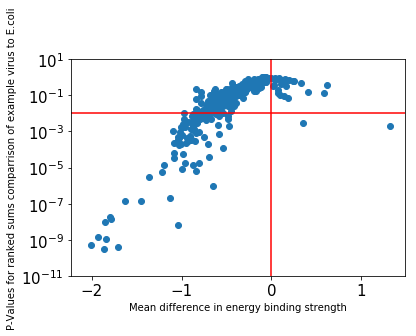

In [23]:
fig, ax = plt.subplots()
ax.set_ylabel("P-Values for ranked sums comparrison of example virus to E.coli")
ax.set_xlabel("Mean difference in energy binding strength")
ax.tick_params(labelsize = 15)
ax.semilogy(mean_difs,p_values, marker = "o", linestyle = "")
ax.axvline(0, color = "r")
ax.axhline(.01, color = "r")
ax.set_ylim(10e-12, 10)

#hides 2 data points 